**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [4]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

In [5]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()

dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [6]:
Gap30 = dv30M.add_formula('gap30', 'close-Delay(open, 1)',add_data=True)

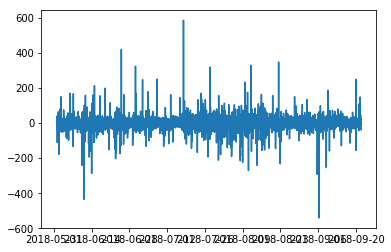

In [7]:
#30min的图
import matplotlib.pyplot as plt


plt.plot(dv30M.get_ts('gap30', date_type='datetime')["BTCUSDT:binance"])
plt.show()

In [8]:
Gap1H = dv1H.add_formula('gap1H', 'close-Delay(open, 1)',add_data=True)

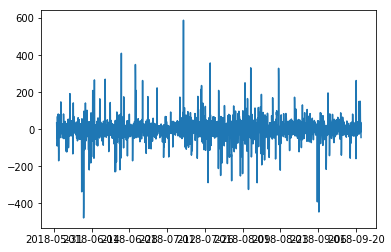

In [9]:
import matplotlib.pyplot as plt


plt.plot(dv1H.get_ts('gap1H', date_type='datetime')["BTCUSDT:binance"])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [10]:
for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),\
                      If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [11]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=5, LongPeriod=20, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
    plt.show()

In [12]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha10_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

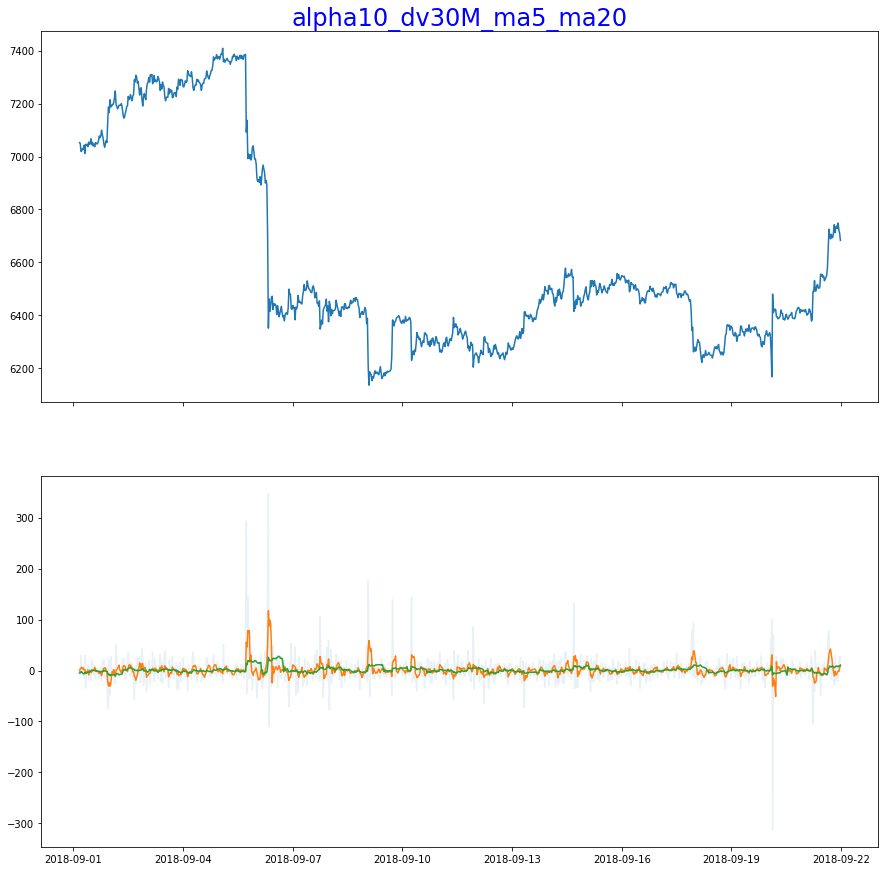

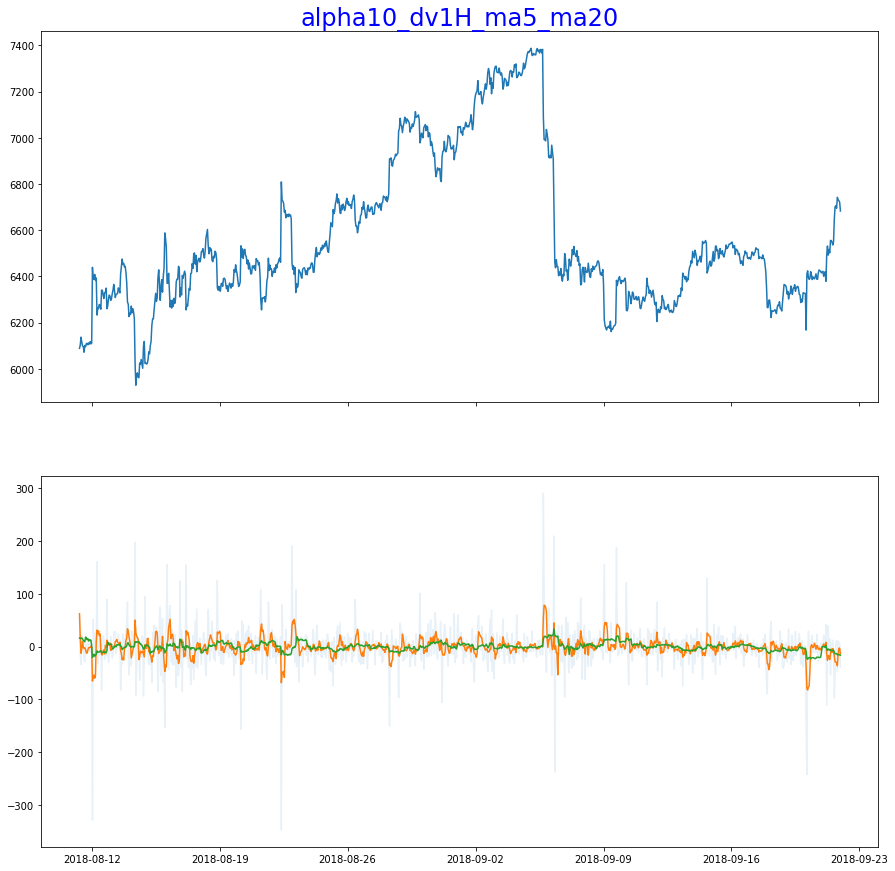

In [13]:
import pandas as pd
for name, alpha in alpha10_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',\
              ShortPeriod=5, LongPeriod=20, n=-1000)

In [14]:
long = dv1H.add_formula("longAlpha1","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && \
                        (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha1","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && \
                        (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

close_long = dv1H.add_formula("closeLongAlpha1","If(shortAlpha1==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha1","If(longAlpha1==2,-1,0)", add_data=True)

In [15]:
dv1H.get_ts('longAlpha1').stack()[dv1H.get_ts('longAlpha1').stack()==2].tail()

trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [16]:
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')
tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha010')
def TimingSignal(td, dv, long, short,closeLong, closeShort, mhp,sl,sp):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [17]:
TimingSignal(tdAlpha1, dv1H,long='longAlpha1',short='shortAlpha1',closeLong='closeLongAlpha1',\
             closeShort='closeShortAlpha1', mhp=100, sl=0.05, sp=0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [18]:
tdAlpha1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [19]:
import warnings
warnings.filterwarnings("ignore")

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

In [20]:
data1H = Time_dict.set_index('datetime')

In [21]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [22]:
import matplotlib.pyplot as plt
#import mpl_finance as mpf
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [23]:
Morning_star=dv1H.add_formula('Morning_star',"If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),\
                            100,0)",add_data=True)

In [24]:
MoringstarVolume=dv1H.get_ts('Morning_star', date_type='datetime')
MoringstarVolume[MoringstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [25]:
MoringstarVolumeX = MoringstarVolume[MoringstarVolume['BTCUSDT:binance']==100].index
MoringstarVolumeY = data1H.loc[MoringstarVolumeX].low-100

In [26]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

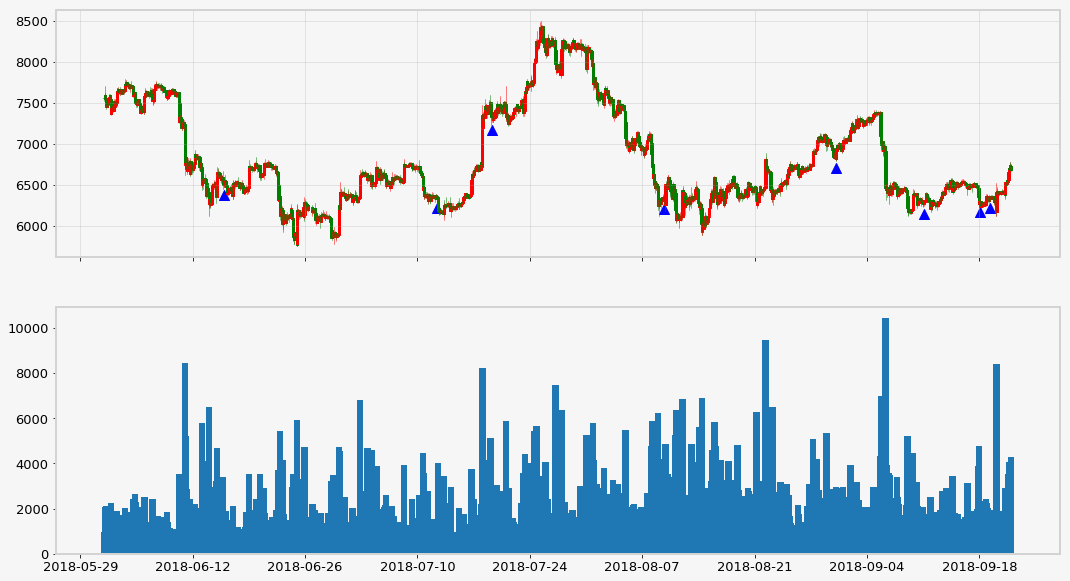

In [27]:
draw_candle(candle, MoringstarVolumeX, MoringstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [63]:
#读取数据：读取比特币数字货币，读取1小时K线图，起始时间是2018.07.01
import warnings
warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol':'BTCUSDT:binance','freq':"1H",
         'start_date':20180701000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

2.4525840282440186


In [64]:
#数据初始化
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H_new = HFDataView()
dv1H_new.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [66]:
#dv1H_new.fields

In [75]:
#1.调用因子1:RSI-相对强弱指标

dv1H_new.add_formula('Ui',"If(close>Delay(close,1),close-Delay(close,1),If(close<Delay(close,1),0,0))",add_data=True)
dv1H_new.add_formula('Di',"If(close>Delay(close,1),0,If(close<Delay(close,1),Delay(close,1)-close,0))",add_data=True)
RSI=dv1H_new.add_formula('RSI_12',"100-100/(1+(Ta('MA',0,Ui,Ui,Ui,Ui,Ui,12)/Ta('MA',0,Di,Di,Di,Di,Di,12)))",add_data=True)

Field [Ui] is overwritten.
Field [Di] is overwritten.
Field [RSI_12] is overwritten.


In [76]:
import matplotlib.pyplot as plt

def plot_chart1(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha.iloc[-1000:],'r', label='RSI_12')
    ax1.axhline(70,alpha=0.3,)
    ax1.axhline(30,alpha=0.3,)
    plt.legend()
    plt.show()

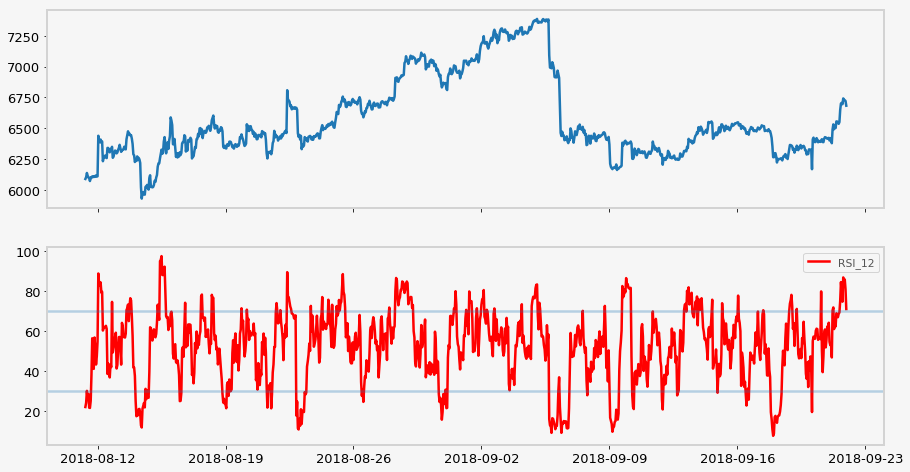

In [77]:
RSI_plot = dv1H_new.get_ts('RSI_12', date_type='datetime')
close1 = dv1H_new.get_ts('close', date_type='datetime')
plot_chart1(close1, RSI_plot)

In [ ]:
#因子1研究报告
#因子：调用技术因子RSI
#现象：画图比较了股票收盘价与多空双方买卖力量相对强弱的关系。
#描述：当RSI取值为50时，股票的买入力量与卖出力量一致，股价不变，RSI取值越大，股票买入力度越大，股票价格会上涨；RSI取值越小，股票卖出力度越大，
     #股票价格会下跌。

In [78]:
#2.调用因子2:ROC-价格变化率
ROC12=dv1H_new.add_formula('ROC12', '((close/Delay(close,12))-1)*100',add_data=True)

In [79]:
import matplotlib.pyplot as plt

def plot_chart2(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-1000:])
    ax1.plot(alpha.iloc[-1000:],'r', label='ROC_12')
    ax1.axhline(0,alpha=0.3,)
    plt.legend()
    plt.show()

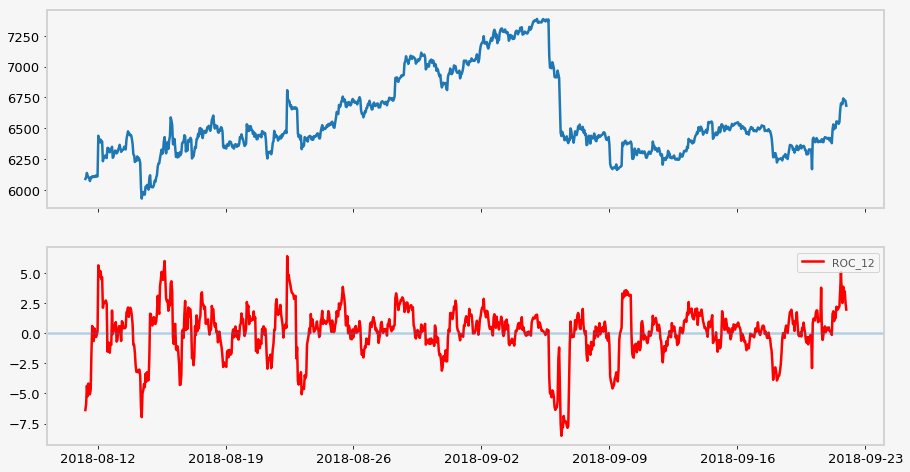

In [80]:
ROC_plot = dv1H_new.get_ts('ROC12', date_type='datetime')
close2 = dv1H_new.get_ts('close', date_type='datetime')
plot_chart2(close2, ROC_plot)

In [ ]:
#因子2研究报告
#因子：调用技术因子ROC
#现象：来反映股票市股价变动的快慢程度，显示当前股价趋势的加速和减速状态
#描述：ROC表示股价上升或下降的速率大小。
    #如果是上升趋势，并且ROC为正值,另外ROC步步上扬,则意味着上升趋势正在加速，若ROC开始走平,这就意味着,
    #股价的涨幅与数天前的股价涨幅相近,尽管还处于上升趋势,但速度已经放慢;若ROC开始回落,虽然股价还在上升,但上升的力量已经衰落;
    #若ROC开始延伸到0之下,下降趋势已开始露头,ROC进一步向下,则下降动力正在加强。
    #下降趋势类似

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

In [ ]:
#因子1:RSI-相对强弱指标
#联系：买方和卖方力量的消长会影响股票的价格。买方力量大，股票上涨；卖方力量大，股票下跌。RSI是衡量买卖双方力量强弱的指标。
#信号：超买超卖现象。当RSI大于80，股票出现超买信号，股票买入力量过大，买入力量在未来可能会减小，所以股票未来价格可能会下跌。
              # 当RSI小于20时，股票出现超卖信号，股票卖出力量过大，卖出力量在未来可能会减小，所以股票未来价格可能会上涨。
#信号进出场假设：
#进场信号，如果RSI<20,买入，做多；或者RSI>80,买入，做空
#出场信号，RSI>80,卖出，平多单；或者RSI<20,卖出，平空单

In [94]:
#dv1H_new.get_ts("RSI_12")

In [117]:
#进场信号，如果RSI<20,买入，做多；或者RSI>80,买入，做空
RSIlong = dv1H_new.add_formula("RSILong","If(RSI_12<20,2,0)",add_data=True)
RSIshort = dv1H_new.add_formula("RSIShort","If(RSI_12>80,-2,0)",add_data=True)
#出场信号，RSI>80,卖出，平多单；或者RSI<20,卖出，平空单
RSIcloselong = dv1H_new.add_formula("RSIcloseLong","If(RSIShort==-2,1,0)",add_data=True)
RSIcloseshort = dv1H_new.add_formula("RSIcloseShort","If(RSILong==2,-1,0)",add_data=True)

Field [RSILong] is overwritten.
Field [RSIShort] is overwritten.
Field [RSIcloseLong] is overwritten.
Field [RSIcloseShort] is overwritten.


In [118]:
#dv1H_new.fields

['datetime',
 'close',
 'high',
 'low',
 'open',
 'volume',
 'RSI_J',
 'Ui',
 'Di',
 'RSI_12',
 'ROC12',
 'RSILong',
 'RSIShort',
 'RSIcloseLong',
 'RSIcloseShort']

In [120]:
dv1H_new.get_ts("RSILong").stack()[dv1H_new.get_ts("RSILong").stack()==2].head()

trade_date      symbol         
20180710170000  BTCUSDT:binance    2.0
20180710180000  BTCUSDT:binance    2.0
20180710190000  BTCUSDT:binance    2.0
20180710200000  BTCUSDT:binance    2.0
20180710210000  BTCUSDT:binance    2.0
dtype: float64

In [ ]:
#因子2:ROC-价格变化率
#联系：ROC是显示一定时间间隔的两头的股价的相对差价。ROC上升,则股价涨幅比数天前的股价有所上升。
      #ROC走平，则当前股价涨幅仅仅同数天前一样。ROC向下，则股价已经比数天前的涨幅小了。
#信号：ROC值是否穿过0基准线。ROC自上而下跌破0,是卖出信号。反之，ROC自下而上穿过0,是买进信号。

#信号进出场假设：
#进场信号，如果出现12日ROC>0且前一个小时的12日ROC<0的信号时,买入,做多;如果出现12日ROC<0且前一个小时的12日ROC>0的信号时,卖出,做空。
#出场信号，如果出现12日ROC<0且前一个小时的12日ROC>0的信号时,平多单;如果出现12日ROC>0且前一个小时的12日ROC<0的信号时,平空单。

In [131]:
dv1H_new.get_ts("ROC12").head()

symbol,BTCUSDT:binance
trade_date,
20180701000000,NaN
20180701010000,NaN
20180701020000,NaN
20180701030000,NaN
20180701040000,NaN


In [132]:
#进场信号,如果出现12日ROC>0且前一个小时的12日ROC<0的信号时,买入,做多;如果出现12日ROC<0且前一个小时的12日ROC>0的信号时,卖出,做空。
ROClong = dv1H_new.add_formula("ROCLong","If((ROC12>0) && (Delay(ROC12,1)<0),2,0)",add_data=True)
ROCshort = dv1H_new.add_formula("ROCShort","If((ROC12<0) && (Delay(ROC12,1)>0),-2,0)",add_data=True)
#出场信号,如果出现12日ROC<0且前一个小时的12日ROC>0的信号时,平多单;如果出现12日ROC>0且前一个小时的12日ROC<0的信号时,平空单。
ROCcloselong = dv1H_new.add_formula("ROCcloseLong","If(ROCShort==-2,1,0)",add_data=True)
ROCcloseshort = dv1H_new.add_formula("ROCcloseShort","If(ROCLong==2,-1,0)",add_data=True)

In [134]:
dv1H_new.fields

['datetime',
 'close',
 'high',
 'low',
 'open',
 'volume',
 'RSI_J',
 'Ui',
 'Di',
 'RSI_12',
 'ROC12',
 'RSILong',
 'RSIShort',
 'RSIcloseLong',
 'RSIcloseShort',
 'ROCLong',
 'ROCShort',
 'ROCcloseLong',
 'ROCcloseShort']

In [137]:
dv1H_new.get_ts("ROCLong").stack()[dv1H_new.get_ts("ROCLong").stack()==2].head()

trade_date      symbol         
20180702050000  BTCUSDT:binance    2.0
20180702100000  BTCUSDT:binance    2.0
20180702150000  BTCUSDT:binance    2.0
20180702200000  BTCUSDT:binance    2.0
20180703150000  BTCUSDT:binance    2.0
dtype: float64

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [ ]:
#因子1:RSI-相对强弱指标  假设落实

In [139]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdRSI = TimingDigger(output_folder=".", output_format='pdf',signal_name='RSI12')

def TimingSignal(td,dv,long,short,closeLong,closeShort,mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [122]:
TimingSignal(tdRSI,dv1H_new,"RSILong","RSIShort","RSIcloseLong","RSIcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 4%


In [126]:
tdRSI.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              13.502 -12.935   -0.185
p-value              0.000   0.000    0.854
mean                 0.035  -0.042   -0.001
std                  0.021   0.025    0.045
info_ratio           1.637  -1.699   -0.016
skewness             0.449   0.163   -0.168
kurtosis            -1.004  -1.493   -1.095
pct5                 0.007  -0.077   -0.072
pct25                0.015  -0.063   -0.051
pct50                0.028  -0.052    0.008
pct75                0.050  -0.017    0.029
pct95                0.072  -0.007    0.070
occurance           69.000  59.000  128.000
win_ratio              NaN     NaN    0.539
win_mean/loss_mean     NaN     NaN    0.823


In [127]:
tdRSI.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               7.436  -7.844  -2.700
p-value              0.000   0.000   0.008
mean                 0.017  -0.037  -0.011
std                  0.015   0.031   0.037
info_ratio           1.147  -1.169  -0.288
skewness             1.061  -0.632  -0.758
kurtosis             0.023  -1.266  -0.070
pct5                 0.001  -0.087  -0.084
pct25                0.006  -0.072  -0.018
pct50                0.011  -0.017  -0.001
pct75                0.026  -0.012   0.010
pct95                0.051  -0.004   0.039
occurance           43.000  46.000  89.000
win_ratio              NaN     NaN   0.483
win_mean/loss_mean     NaN     NaN   0.473


In [128]:
tdRSI.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               14.136  -14.483   -1.667
p-value               0.000    0.000    0.097
mean                  0.028   -0.040   -0.005
std                   0.021    0.028    0.042
info_ratio            1.342   -1.420   -0.113
skewness              0.714   -0.251   -0.264
kurtosis             -0.577   -1.429   -0.693
pct5                  0.003   -0.083   -0.078
pct25                 0.011   -0.066   -0.024
pct50                 0.025   -0.044    0.002
pct75                 0.044   -0.014    0.026
pct95                 0.070   -0.006    0.062
occurance           112.000  105.000  217.000
win_ratio               NaN      NaN    0.516
win_mean/loss_mean      NaN      NaN    0.706


In [ ]:
#因子2:ROC-价格变化率   假设落实

In [140]:
tdROC = TimingDigger(output_folder=".", output_format='pdf',signal_name='ROC12')
TimingSignal(tdROC,dv1H_new,"ROCLong","ROCShort","ROCcloseLong","ROCcloseShort",mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%


In [141]:
tdROC.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               4.581  -9.144   -0.178
p-value              0.000   0.000    0.859
mean                 0.011  -0.007   -0.000
std                  0.018   0.008    0.016
info_ratio           0.602  -0.933   -0.014
skewness             2.821  -2.617    2.631
kurtosis             8.565  10.769   13.555
pct5                 0.000  -0.020   -0.018
pct25                0.001  -0.009   -0.006
pct50                0.004  -0.005   -0.001
pct75                0.010  -0.002    0.002
pct95                0.051  -0.000    0.025
occurance           59.000  97.000  156.000
win_ratio              NaN     NaN    0.378
win_mean/loss_mean     NaN     NaN    1.561


In [142]:
tdROC.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               4.701  -8.233   -0.503
p-value              0.000   0.000    0.615
mean                 0.011  -0.008   -0.001
std                  0.018   0.009    0.016
info_ratio           0.623  -0.832   -0.040
skewness             2.125  -2.612    1.699
kurtosis             3.606   8.231    7.531
pct5                 0.000  -0.028   -0.019
pct25                0.001  -0.010   -0.006
pct50                0.003  -0.005   -0.001
pct75                0.012  -0.002    0.002
pct95                0.055  -0.000    0.030
occurance           58.000  99.000  157.000
win_ratio              NaN     NaN    0.369
win_mean/loss_mean     NaN     NaN    1.477


In [144]:
tdROC.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                6.591  -12.172   -0.488
p-value               0.000    0.000    0.626
mean                  0.011   -0.007   -0.000
std                   0.018    0.009    0.016
info_ratio            0.612   -0.872   -0.028
skewness              2.476   -2.670    2.130
kurtosis              6.099    9.572   10.295
pct5                  0.000   -0.022   -0.018
pct25                 0.001   -0.010   -0.006
pct50                 0.004   -0.005   -0.001
pct75                 0.010   -0.002    0.002
pct95                 0.055   -0.000    0.028
occurance           117.000  196.000  313.000
win_ratio               NaN      NaN    0.374
win_mean/loss_mean      NaN      NaN    1.517
